# ***Accuracy***

In [ ]:
import torch
import torch.backends.quantized
torch.backends.quantized.engine = "onednn"

from utils.utils import get_quantized_models
from utils.train import train_one_epoch, evaluate, eval_qat_model
from utils.data import prepare_data_loaders


data_train, data_eval = prepare_data_loaders(128, 100)
names = ["resnet18", "resnet34", "resnet50", "mobilenet", "vit_b_16"]
w_bits = [2, 3, 4]
results = []
for name in names:
    device = 'cuda' if 'vit' in name else 'cpu'
    for w_bit in w_bits:
        model = get_quantized_models(name, w_bit)
        if model is not None:
            model.eval()
            model.to(device)
            top1, top5 = evaluate(model, data_eval, device=device)
            results.append([f'{name}_w{w_bit}', top1.avg.item(), top5.avg.item()])

print("model        top1    top5")
for name, top1, top5 in results:
    print(f"{name:<13}{top1:<8.3f}{top5:.3f}")
# for Table IV

# ***Degeneracy***

In [5]:
import math
import torch
import matplotlib.pyplot as plt
from utils.utils import get_quantized_models


def calculate_power_2(x):
    min_bits = 0
    while x:
        x //= 2
        min_bits += 1
    return 8 * 2**(math.ceil(math.log2(min_bits / 8)))

def reorganize(w, NR):
    # w's shape: [outc, inc, k, k] or [outc, inc]
    outc = w.shape[0]
    if w.dim() == 2:
        w = w.transpose(0, 1)  # [inc, outc]
    elif w.dim() == 4:
        w = w.permute(1, 2, 3, 0).reshape(-1, outc)  # [inc, k, k, outc]
    else:
        print("wrong shape of weight tensor")
        return
    # 列方向按NR进行分割, 不足NR的补0
    k, n = w.shape
    if n % NR != 0:
        res = NR - (n % NR)
        w = torch.cat((w, torch.zeros([w.shape[0], res], dtype=torch.int)), dim=1)
    w = w.reshape(k, -1, NR)
    w = w.permute(1, 0, 2)  # [n // NR, k, NR]
    w = w.reshape(-1, NR)  # [(n // NR) * k, NR]
    return w  # [-1, NR]


def print_degeneracy(model_name='resnet18', w_bits=[2, 3, 4], length_vector=8):
    lv = length_vector
    tus = []
    adict = {}
    for w_bit in w_bits:
        qmodel = get_quantized_models(model_name, w_bit)
        codebook = set()
        total_p = 0

        for layer_name, mod in qmodel.named_modules():
            if hasattr(mod, 'weight'):
                w = mod.weight().int_repr().detach()
                total_p += w.numel()
                w = reorganize(w, lv)
                num_unique = 0
                for i in range(w.shape[0]):
                    tmp = tuple(w[i].tolist())
                    if tmp not in codebook:
                        codebook.add(tmp)
                        num_unique += 1

                if layer_name not in adict:
                    adict[layer_name] = {
                        'num_paras': 0, 'num_vectors': 0, 'num_uniques': []
                        }
                adict[layer_name]["num_paras"] = w.numel()
                adict[layer_name]['num_vectors'] = w.shape[0]
                adict[layer_name]['num_uniques'].append(num_unique)
        tp = total_p
        tus.append(len(codebook))

    tnv = (tp - 1) // lv + 1
    bsize = [
        tnv * lv * 32 / 8 / 2**20,
        tus[0] * lv * 8 / 8 / 2**20,
        tus[1] * lv * 8 / 8 / 2**20,
        tus[2] * lv * 8 / 8 / 2**20,
    ]
    rs = [calculate_power_2(x) for x in tus]
    # 间隔
    print(f"{'name':<23}{'num_p':<9}{'num_v':<13}num_unique")
    print(f"{' ':<41}2-bit  3-bit  4-bit")
    for k, v in adict.items():
        np, nv, nus = v['num_paras'], v['num_vectors'], v['num_uniques']
        print(f'{k:<23}{np:<9}{nv:<9}{nus[0]:<7}{nus[1]:<7}{nus[2]:<7}')
    print(f"{'total':<23}{tp:<9}{tnv:<9}{tus[0]:<7}{tus[1]:<7}{tus[2]:<7}")
    print(f"{'ratio':<32}{tnv/tnv:<9}{tus[0]/tnv:<7.4f}{tus[1]/tnv:<7.4f}{tus[2]/tnv:<7.4f}")
    print(f"B_{lv:<30}{bsize[0]:<9.4f}{bsize[1]:<7.4f}{bsize[2]:<7.4f}{bsize[3]:<7.4f}")
    print(
        f"r_{lv:<39}{rs[0]:<2}/{8*lv:<4}{rs[1]:<2}/{8*lv:<4}{rs[2]:<2}/{8*lv:<4}"
    )


def search_best_length(model_name='vit_b_16', w_bit=4, lengths=[4, 6, 8, 10, 12]):
    model = get_quantized_models(model_name, w_bit)
    Bs = []
    rs = []
    for l in lengths:
        codebook = set()
        # total_p = 0

        for mod in model.modules():
            if "vit" not in model_name:
                if hasattr(mod, "weight"):
                    w = mod.weight().int_repr().detach()
                else:
                    continue
            else:
                if hasattr(mod, "in_proj_weight"):
                    w = mod.in_proj_weight / mod.qscale
                elif hasattr(mod, "weight") and not isinstance(mod, torch.nn.LayerNorm):
                    w = mod.weight / mod.qscale
                else:
                    continue
                w = w.int().detach()

            w = reorganize(w, l)
            for i in range(w.shape[0]):
                tmp = tuple(w[i].tolist())
                if tmp not in codebook:
                    codebook.add(tmp)

        total_u = len(codebook)
        Bs.append(total_u * l * 8 / 8 / 2**20)  # MB
        rs.append(calculate_power_2(total_u) / (8 * l))
    print('Bs: ', end='')
    for b in Bs:
        print(f'{b:<9.4f}', end='')
    print('\nrs: ', end='')
    for r in rs:
        print(f"{r:<9.4f}", end='')
    print('\n')

    return Bs, rs

In [4]:
# Table I
print_degeneracy(model_name="resnet18", w_bits=[2, 3, 4], length_vector=8)

name                   num_p    num_v        num_unique
                                         2-bit  3-bit  4-bit
conv1                  9408     1176     675    1066   1159   
layer1.0.conv1         36864    4608     707    2410   3758   
layer1.0.conv2         36864    4608     146    1666   4403   
layer1.1.conv1         36864    4608     451    2944   4465   
layer1.1.conv2         36864    4608     104    1623   4317   
layer2.0.conv1         73728    9216     1432   5910   8816   
layer2.0.conv2         147456   18432    527    4920   15338  
layer2.0.downsample.0  8192     1024     45     599    965    
layer2.1.conv1         147456   18432    195    4089   15027  
layer2.1.conv2         147456   18432    117    3836   15999  
layer3.0.conv1         294912   36864    332    6961   29900  
layer3.0.conv2         589824   73728    283    7598   48768  
layer3.0.downsample.0  32768    4096     79     1487   3708   
layer3.1.conv1         589824   73728    396    8782   52382  
l

### Search best vector length

In [6]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
matplotlib.rcParams['font.family'] = 'Times New Roman'
# matplotlib.rcParams['svg.fonttype'] = 'none'

def plot_search_result(ax1, Bs, rs, lengths, Bmax=4):
    # the index of optimal length
    besti = 0
    for limit in range(len(Bs)):
        if Bs[limit] > Bmax:
            break
        if rs[besti] > rs[limit]:
            besti = limit

    ax2 = ax1.twinx()
    bar_width = 0.35
    bar_positions1 = np.arange(len(lengths))
    bar_positions2 = bar_positions1 + bar_width

    ax1.bar(bar_positions1, rs, width=bar_width, label="r", color="tab:blue")
    ax2.bar(bar_positions2, Bs, width=bar_width, label="B", color="tab:orange")
    ax1.text(bar_positions1[besti], rs[besti], f'{rs[besti]:.3f}', ha='center', va='bottom', zorder=99)

    ax1.set_xlabel("Vector lengths", fontsize=11)
    ax1.set_ylabel("Values for r", fontsize=11)
    ax1.set_ylim([0., 1.])
    ax2.set_ylabel("Values for B (MB)", fontsize=11)

    ax1.set_xticks(bar_positions1 + bar_width / 2)
    ax1.set_xticklabels(lengths)

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper center")
    plt.axhline(y=Bmax, linestyle='--', color='gray')

In [ ]:
# Table II
lengths = [8]
search_best_length(model_name="resnet18", w_bit=4, lengths=lengths)
search_best_length(model_name="resnet18", w_bit=3, lengths=lengths)
search_best_length(model_name="resnet18", w_bit=2, lengths=lengths)

search_best_length(model_name="resnet34", w_bit=4, lengths=lengths)
search_best_length(model_name="resnet34", w_bit=3, lengths=lengths)
search_best_length(model_name="resnet34", w_bit=2, lengths=lengths)

search_best_length(model_name="resnet50", w_bit=4, lengths=lengths)
search_best_length(model_name="resnet50", w_bit=3, lengths=lengths)
search_best_length(model_name="resnet50", w_bit=2, lengths=lengths)

search_best_length(model_name="mobilenet", w_bit=4, lengths=lengths)
search_best_length(model_name="mobilenet", w_bit=3, lengths=lengths)

search_best_length(model_name="vit_b_16", w_bit=4, lengths=lengths)
search_best_length(model_name="vit_b_16", w_bit=3, lengths=lengths)
search_best_length(model_name="vit_b_16", w_bit=2, lengths=lengths)

Bs: 6.4914   
rs: 0.5000   

Bs: 0.9801   
rs: 0.5000   

Bs: 0.0565   
rs: 0.2500   

Bs: 11.2010  
rs: 0.5000   

Bs: 1.7455   
rs: 0.5000   

Bs: 0.1264   
rs: 0.2500   

Bs: 13.6587  
rs: 0.5000   

Bs: 1.6445   
rs: 0.5000   

Bs: 0.0756   
rs: 0.2500   

Bs: 3.2761   
rs: 0.5000   

Bs: 2.0886   
rs: 0.5000   

Bs: 43.1215  
rs: 0.5000   

Bs: 4.8553   
rs: 0.5000   

Bs: 0.1265   
rs: 0.2500   



([0.12646484375], [0.25])

In [ ]:
# Fig. 5
lengths = [4, 5, 6, 7, 8, 9, 10, 11, 12]

# ResNet-18
R_Bs4, R_rs4 = search_best_length(model_name="resnet18", w_bit=4, lengths=lengths)
R_Bs3, R_rs3 = search_best_length(model_name="resnet18", w_bit=3, lengths=lengths)

# MobileNet
M_Bs4, M_rs4 = search_best_length(model_name="mobilenet", w_bit=4, lengths=lengths)
M_Bs3, M_rs3 = search_best_length(model_name="mobilenet", w_bit=3, lengths=lengths)

# Vit-b-16
V_Bs4, V_rs4 = search_best_length(model_name="vit_b_16", w_bit=4, lengths=lengths)
V_Bs3, V_rs3 = search_best_length(model_name="vit_b_16", w_bit=3, lengths=lengths)

Bs: 0.0990   0.5075   1.6512   3.7752   6.4914   8.8263   10.2496  10.8620  11.0979  
rs: 0.5000   0.8000   0.6667   0.5714   0.5000   0.4444   0.4000   0.3636   0.3333   

Bs: 0.0108   0.0520   0.1758   0.4563   0.9801   1.7732   2.8143   4.0326   5.2976   
rs: 0.5000   0.4000   0.3333   0.5714   0.5000   0.4444   0.4000   0.3636   0.3333   

Bs: 0.1963   1.0399   2.3284   3.0978   3.2761   3.3181   3.3230   3.3343   3.3425   
rs: 0.5000   0.8000   0.6667   0.5714   0.5000   0.4444   0.4000   0.3636   0.3333   

Bs: 0.0156   0.1335   0.5658   1.3027   2.0886   2.6396   2.9230   3.0785   3.1451   
rs: 0.5000   0.4000   0.6667   0.5714   0.5000   0.4444   0.4000   0.3636   0.3333   

Bs: 0.2001   1.6482   7.7492   22.4865  43.1215  60.4842  70.6084  75.4980  77.7297  
rs: 0.5000   0.8000   0.6667   0.5714   0.5000   0.4444   0.4000   0.3636   0.3333   

Bs: 0.0150   0.1058   0.5054   1.7614   4.8553   10.7624  19.7988  30.8921  42.2358  
rs: 0.5000   0.4000   0.6667   0.5714   0.5000   

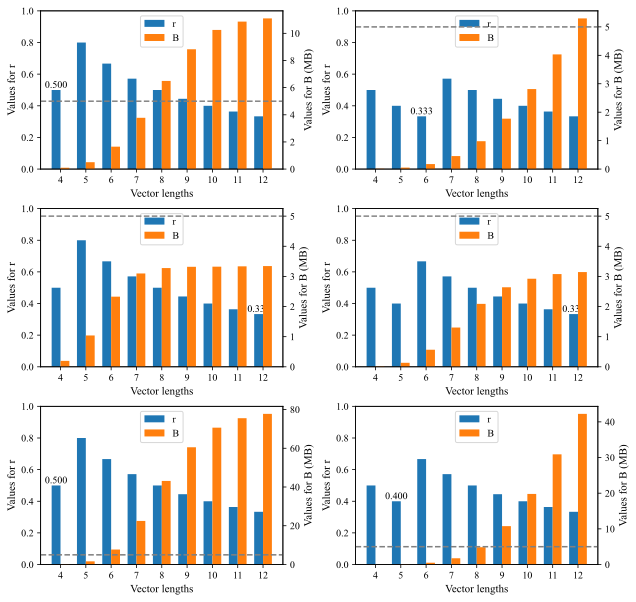

In [5]:
fig, axs = plt.subplots(3, 2)
# 设置图形大小（单位为英寸），这里设置宽为8英寸，高为4英寸
fig.set_size_inches(10, 10)
# 调整子图之间的水平和垂直间距，这里设置水平间距为0.5，垂直间距为0.5
fig.subplots_adjust(wspace=0.3, hspace=0.25)

plot_search_result(axs[0][0], R_Bs4, R_rs4, lengths, Bmax=5)
plot_search_result(axs[0][1], R_Bs3, R_rs3, lengths, Bmax=5)

plot_search_result(axs[1][0], M_Bs4, M_rs4, lengths, Bmax=5)
plot_search_result(axs[1][1], M_Bs3, M_rs3, lengths, Bmax=5)

plot_search_result(axs[2][0], V_Bs4, V_rs4, lengths, Bmax=5)
plot_search_result(axs[2][1], V_Bs3, V_rs3, lengths, Bmax=5)

plt.show()

## Full-connected Layer with DWC and DMM

In [2]:
import os
import math
import numpy as np
from collections import OrderedDict
import itertools

import torch
import matplotlib.pyplot as plt
from utils.utils import get_quantized_models


def reorganize(w, NR):
    # w's shape: [outc, inc, k, k] or [outc, inc]
    outc = w.shape[0]
    if w.dim() == 2:
        w = w.transpose(0, 1)  # [inc, outc]
    elif w.dim() == 4:
        w = w.permute(1, 2, 3, 0).reshape(-1, outc) # [inc, k, k, outc]
    else:
        print("wrong shape of weight tensor")
        return

    k, n = w.shape
    if n % NR != 0:
        res = NR - (n % NR)
        w = torch.cat((w, torch.zeros([w.shape[0], res], dtype=torch.int)), dim=1)
    w = w.reshape(k, -1, NR)
    w = w.permute(1, 0, 2)  # [n // NR, k, NR]
    w = w.reshape(-1, NR)   # [(n // NR) * k, NR]
    return w, k    # [-1, NR]


def build_codebook_encodings(model_name="vit_b_16", w_bit=4, NR=8):
    model = get_quantized_models(model_name, w_bit)
    codebook = OrderedDict()
    encodings = dict()
    index = 0

    for name, mod in model.named_modules():
        if "vit" not in model_name:
            if hasattr(mod, "weight"):
                w = mod.weight().int_repr().detach()
            else:
                continue
        else:
            if hasattr(mod, "in_proj_weight"):
                w = mod.in_proj_weight / mod.qscale
            elif hasattr(mod, "weight") and not isinstance(mod, torch.nn.LayerNorm):
                w = mod.weight / mod.qscale
            else:
                continue
            w = w.int().detach()

        encoding = []
        w, k = reorganize(w, NR)  # [-1, NR]
        
        for i in range(w.shape[0]):
            vector = tuple(w[i].tolist())
            if vector not in codebook:
                encoding.append(index)
                codebook[vector] = index
                index += 1
            else:
                encoding.append(codebook[vector])
        encodings[name] = (encoding, k)
    print(f"The number of unique vectors is {index}.")
    return codebook, encodings


def save_weight(model_name="vit_b_16", w_bit=2, layer_name='heads.head', save_path='path'):
    model = get_quantized_models(model_name, w_bit)
    for name, mod in model.named_modules():
        if "vit" not in model_name:
            if name == layer_name:
                w = mod.weight().int_repr().detach()
            else:
                continue
        else:
            if hasattr(mod, "in_proj_weight") and name == layer_name:
                w = mod.in_proj_weight / mod.qscale
            elif hasattr(mod, "weight") and name == layer_name:
                w = mod.weight / mod.qscale
            else:
                continue
            w = w.int().detach()

        w = np.array(w.reshape(-1), dtype=np.int8)
        with open(save_path, "wb") as f:
            w.tofile(f)
        print(f"weight's shape: {len(w)}")
        for i in range(10):
            print(w[i], end=' ')


def save_dwc_data(
    codebook,
    encodings,
    ec_name='fc',
    cb_path="codebook",
    ec_path="encodings",
    shape_path="shape",
    folder='saved_data/'
):
    if not os.path.exists(folder):
        os.makedirs(folder)
    codebook_data = np.array(list(itertools.chain(*codebook.keys())), dtype=np.int8)
    with open(folder + cb_path + '.bin', 'wb') as f:
        codebook_data.tofile(f)

    encoding, k = encodings[ec_name]
    max_value = max(encoding)
    print(f'The max value in Encoding is: {max_value}')
    if max_value < 2**8:
        encoding_data = np.array(encoding, dtype=np.uint8)
        typeId = 0
    elif max_value < 2**16:
        encoding_data = np.array(encoding, dtype=np.uint16)
        typeId = 1
    else:
        encoding_data = np.array(encoding, dtype=np.uint32)
        typeId = 2
    print(f"The typeId is: {typeId}")

    with open(folder + ec_path + '.bin', 'wb') as f:
        encoding_data.tofile(f)

    # 保存数组尺寸信息
    with open(folder + shape_path + '.bin', 'wb') as f:
        # 四个数据分别是cb的大小, ec的行列, 以及ec的类型号
        shapes = np.array(
            [len(codebook_data), k, len(encoding_data) // k, typeId], dtype=np.int32
        )
        shapes.tofile(f)
        print(f"codebook's size: {shapes[0]}")
        for i in range(10):
            print(codebook_data[i], end=' ')
        print(f"\nencoding's shape: {shapes[1]}x{shapes[2]}")
        for i in range(10):
            print(encoding[i], end=" ")

In [3]:
NR = 8
model_name = "resnet18"
layer_name = "fc"
save_path = "./DWC_DMM/matrix_data"

for bit in range(2, 5):
    print(f"bit: {bit}")
    cb, ec = build_codebook_encodings(model_name, bit, NR)

    save_dwc_data(
        cb,
        ec,
        layer_name,
        "codebook",
        "encoding",
        "shape",
        f"{save_path}/{model_name}/{bit}_{NR}/",
    )
    print("\n")
    save_weight(
        model_name,
        bit,
        layer_name,
        f"{save_path}/{model_name}/{bit}_{NR}/weights.bin",
    )
    print("\n")

bit: 2
The number of unique vectors is 7400.
The max value in Encoding is: 7399
The typeId is: 1
codebook's size: 59200
0 0 0 0 0 0 -1 0 0 0 
encoding's shape: 512x125
28 1 1 4286 1 139 138 1462 278 1 

weight's shape: 512000
0 0 0 0 0 0 0 1 0 0 

bit: 3
The number of unique vectors is 128463.
The max value in Encoding is: 128462
The typeId is: 2
codebook's size: 1027704
0 0 0 0 0 0 -1 0 0 0 
encoding's shape: 512x125
8353 3488 2490 125034 536 8810 3925 125035 3654 2490 

weight's shape: 512000
0 -1 -1 0 0 0 0 3 0 -1 

bit: 4
The number of unique vectors is 850835.
The max value in Encoding is: 850834
The typeId is: 2
codebook's size: 6806680
0 0 0 -1 0 -1 -1 0 0 0 
encoding's shape: 512x125
827529 827530 384092 827531 4493 827532 815514 827533 72550 319894 

weight's shape: 512000
0 -2 -1 0 0 0 -1 6 -1 -1 



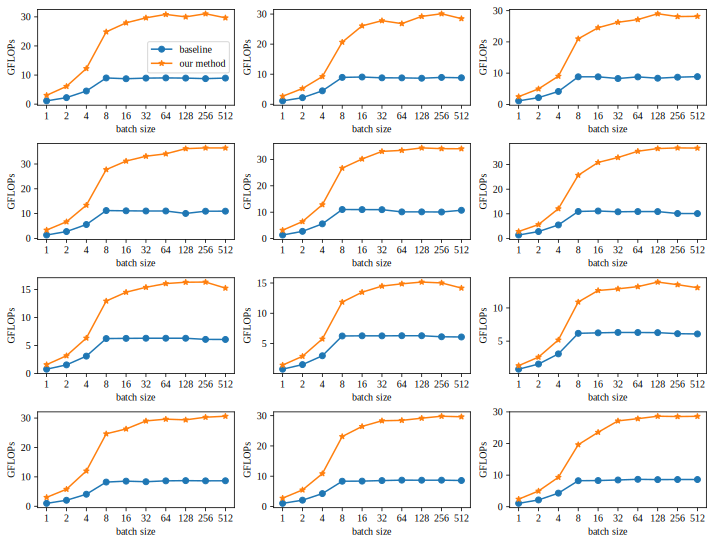

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import os
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
matplotlib.rcParams['font.family'] = 'Times New Roman'
matplotlib.rcParams['svg.fonttype'] = 'none'

# Figure 7
CPUs = ['7840HS', '7900X', '9750H', '13100F']
bits = [2, 3, 4]
def plot_figure_7(CPUs, bits):
    data_path = './exp_data'
    model_name = 'resnet18'
    x = list(range(10))
    m = [2**i for i in x]
    info = [['regular', 'o', 'baseline'], ['custom', '*', 'our method']]
    
    H, W = len(CPUs), len(bits)
    fig, axs = plt.subplots(H, W)
    fig.set_size_inches(12, 9)
    fig.subplots_adjust(wspace=0.2, hspace=0.4)
    
    first = 0
    for h in range(H):
        for w in range(W):
            ax = axs[h][w]
            ax.set_xticks(x, m)
            ax.set_xlabel('batch size')
            ax.set_ylabel('GFLOPs')
            for name1, marker, name2 in info:
                file_name = f"{model_name}_{name1}_{bits[w]}.txt"
                file_path = os.path.join(data_path, os.path.join(CPUs[h], file_name))
                
                with open(file_path, 'r') as f:
                    line = f.read()
                    data = [float(i) for i in line.split(',') if i]
                
                ax.plot(x, data, marker=marker, label=name2)
                if first < 2:
                    first += 1
                    axs[h][w].legend()


plot_figure_7(CPUs, bits)